# Ритейл - анализ программ лояльности
## Материалы
* Презентация: https://drive.google.com/file/d/1mnYLfcybwcgQhPzxxG22Lg8b7bR42yEb/view?usp=sharing
* Дашборд: https://public.tableau.com/views/retail_16271064673040/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link


Перед нами стоит задача - узнать на сколько хорошо или плохо работает программа лояльности в магазине строительных материалов. К нам поступили данные из отдела маркетинга, описание данных:

Файл retail_dataset.csv:

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;

Файл product_codes.csv:

- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара;
## Откроем файл с данными и изучим общую информацию


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px




retail_dataset=pd.read_csv('/datasets/retail_dataset.csv')
product_codes=pd.read_csv('/datasets/product_codes.csv')
display(retail_dataset.head(10))
print(retail_dataset.info())
print(retail_dataset.describe())



,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0
5,538379,22965,0,2016-12-12 11:26:00,22805.0,Shop 0,1.0
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
9,539501,22372,0,2016-12-20 11:08:00,22764.0,Shop 0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchaseid         105335 non-null object
item_ID            105335 non-null object
Quantity           105335 non-null int64
purchasedate       105335 non-null object
CustomerID         69125 non-null float64
ShopID             105335 non-null object
loyalty_program    105335 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB
None
            Quantity    CustomerID  loyalty_program
count  105335.000000  69125.000000    105335.000000
mean        7.821218  21019.302047         0.226345
std       327.946695   1765.444679         0.418467
min    -74216.000000  18025.000000         0.000000
25%         0.000000  19544.000000         0.000000
50%         2.000000  20990.000000         0.000000
75%         7.000000  22659.000000         0.000000
max     74214.000000  23962.000000         1.000000


После первого взгляда на данные уже можно заметить моменты, с которыми стоит разобраться перед началом анализа. Например, пропуски в столбце `CustomerID`, отрицательные значения в столбце `Quantity` - это могут быть возвраты, неудобные название столбцов, типы данных. 
Со всем этим мы разберемся дальше. 

In [2]:
display(product_codes.head())
print(product_codes.info())
print(product_codes.describe())

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
productID        9969 non-null object
price_per_one    9969 non-null float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB
None
       price_per_one
count    9969.000000
mean       19.503697
std       330.880754
min         0.000000
25%         1.250000
50%         2.550000
75%         5.510000
max     16888.020000


В этой таблицк так же предстоит изменить тип данных, и разобраться чем вызвано такое большое значение std и разница между 75% и max. Строки со значением цены за еденицу товара и количеством товара равной нулю можно удалить, скорее всего это ошибка или выброс. 

## Подготовим данные



In [3]:
print(product_codes.loc[product_codes['price_per_one']==0,'price_per_one'].count()/product_codes.shape[0])
print(retail_dataset.loc[retail_dataset['Quantity']==0,'loyalty_program'].count()/retail_dataset.shape[0])
#удаляем нулевые значения, потому что они составляют небольшой процент от всех данных
product_codes=product_codes.query('price_per_one!=0')
#заменим нулевые значения на средние для количества товаров, потому что таких значений больше 30% и удалять их нельзя
retail_dataset.loc[retail_dataset['Quantity']==0,'Quantity']=retail_dataset['Quantity'].median()
print(product_codes.loc[product_codes['price_per_one']==0,'price_per_one'].count()/product_codes.shape[0])
print(retail_dataset.loc[retail_dataset['Quantity']==0,'loyalty_program'].count()/retail_dataset.shape[0])


0.03831878824355502
0.31380832581762946
0.0
0.0


### Переименуем столбцы


In [4]:
retail_dataset=retail_dataset.rename(columns={'purchaseid':'purchase_id','item_ID':'item_id','Quantity':'quantity','purchasedate':'purchase_date','CustomerID':'customer_id','ShopID':'shop_id'})
product_codes=product_codes.rename(columns={'productID':'item_id'})

### Определим и заполним пропущенные значения. 


In [41]:
print(retail_dataset.isnull().sum()/retail_dataset.shape[0])
print(product_codes.isnull().sum()/product_codes.shape[0])


purchase_id        0.0
item_id            0.0
quantity           0.0
purchase_date      0.0
customer_id        0.0
shop_id            0.0
loyalty_program    0.0
dtype: float64
item_id          0.0
price_per_one    0.0
dtype: float64


У нас присутвтуют пропуски только в столбцах с ID покупателя. Это могут быть неиденефицироанные пользователи. Удалять эти пропуски слишком опасно, их у нас больше 30%, так что заменим их на нули, а при дальнейшем анализе будем учитывать, что нули - это неидентифицироанные пользователи и в зависимости от ситуации брать их в расчет или нет. 

In [6]:
retail_dataset.loc[(retail_dataset['customer_id'].isna()),'customer_id']=0
print(retail_dataset.isnull().sum())


purchase_id        0
item_id            0
quantity           0
purchase_date      0
customer_id        0
shop_id            0
loyalty_program    0
dtype: int64


### Изменим типы данных

Для более корректной работы приведем данные к нужным типам, сделаем дату - датой, а участие в программе лояльности сделаем int, потому что foat нам там не нужен. 

In [7]:
retail_dataset['purchase_date']=pd.to_datetime(retail_dataset['purchase_date'])
#retail_dataset['customer_id']=retail_dataset['customer_id'].astype(int)
retail_dataset['loyalty_program']=retail_dataset['loyalty_program'].astype(int)




### Работа с дубликатами

In [42]:
print(retail_dataset.duplicated().sum()/retail_dataset.shape[0])
retail_dataset =retail_dataset.drop_duplicates().reset_index(drop=True)
retail_dataset.duplicated().sum()


0.0


0

Безболезнено удаляем дубликаты, потому что их в нашем дата сете меньше одного процента. 

In [9]:
print(product_codes.duplicated().sum())


0


In [10]:
len(product_codes['item_id'].unique())

3102

Полных дубликатов во втором датасете нет, однако уникальных ID всего 3159. Для каждого уникального ID посчитаем среднюю цену за еденицу товара. 

In [11]:
for every in product_codes['item_id'].unique():
    mean=product_codes.loc[product_codes['item_id']==every,'price_per_one'].mean()
    product_codes.loc[product_codes['item_id']==every,'price_per_one']=mean
    


Для каждого ID продукта посчитали среднее значение цены среди продуктов с таким же ID и заменили все значения в строках с таким ID на среднее значение. Теперь у нас образовались дубликаты, которые можно удалить, тем самым сократив наш датасет.

In [12]:
print(product_codes.duplicated().sum())
product_codes =product_codes.drop_duplicates().reset_index(drop=True)
product_codes.duplicated().sum()

6485


0

## Почитаем и добавим в таблицу
Объеденим данные из двух таблиц, чтобы посчитать чек по покупке.

In [13]:
data = retail_dataset.merge(product_codes, on=['item_id'], how='left')


In [14]:
display(data.head())
data.info()


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one
0,538280,21873,11.0,2016-12-10 12:50:00,18427.0,Shop 0,0,1.810000
1,538862,22195,2.0,2016-12-14 14:11:00,22389.0,Shop 0,1,2.766667
2,538855,21239,7.0,2016-12-14 13:50:00,22182.0,Shop 0,1,1.474000
3,543543,22271,2.0,2017-02-09 15:33:00,23522.0,Shop 0,1,4.300000
4,543812,79321,2.0,2017-02-13 14:40:00,23151.0,Shop 0,1,7.715000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 104167 entries, 0 to 104166
Data columns (total 8 columns):
purchase_id        104167 non-null object
item_id            104167 non-null object
quantity           104167 non-null float64
purchase_date      104167 non-null datetime64[ns]
customer_id        104167 non-null float64
shop_id            104167 non-null object
loyalty_program    104167 non-null int64
price_per_one      104108 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 7.2+ MB


In [15]:
data.duplicated().sum()


0

### Добавим столбец с чеком - сколько заплатили за товары при покупке

In [16]:
data['bill']=data['price_per_one']*data['quantity']
data.describe()

,quantity,customer_id,loyalty_program,price_per_one,bill
count,104167.000000,104167.000000,104167.000000,104108.000000,104108.000000
mean,8.511976,13721.644513,0.224207,6.129548,24.329315
std,329.765394,10101.984719,0.417061,96.383413,460.024192
min,-74216.000000,0.000000,0.000000,0.120000,-77184.640000
25%,2.000000,0.000000,0.000000,1.820000,4.740000
50%,2.000000,19421.000000,0.000000,2.985000,10.980000
75%,7.000000,21690.000000,0.000000,5.555000,22.806667
max,74214.000000,23962.000000,1.000000,9268.762222,77182.560000


### Проверим столбцы на наличие выбросов и необычных значений, найдем им объяснение и решим учитывать ли их при анализе

Построим боксплоты для суммы чека, количества товара, стоимости одной еденицы товара

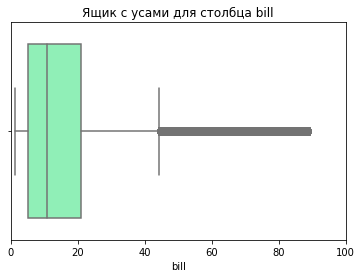

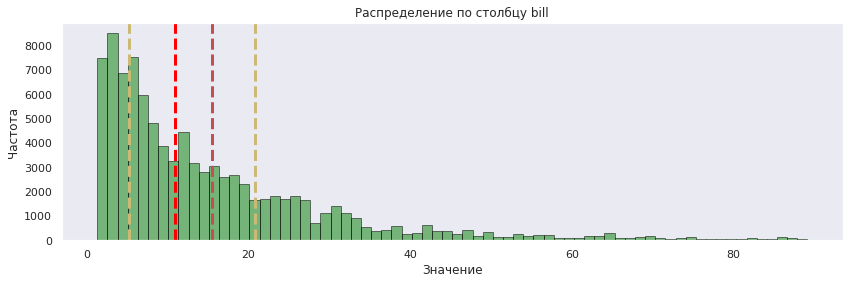

-----------------------------------------------------------


In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
def num_of_bins(data,value):# определяем количество корзин 
    if data[value].max()>100:
        return 70
    elif data[value].max()>500:
        return 150
    elif data[value].max()>1000:
        return 200
    else: return 30

def my_hist(data,col):# функция для построения ящика с усами и гистограммы
    my_col=data.loc[(data[col]>=data[col].quantile(.05))&(data[col]<=data[col].quantile(.95)),col]# отбрасываем крайние значения
    sns.set(rc={'figure.figsize':(10,6)})
    sns.boxplot(x=my_col, palette="rainbow")
    ax.set_xlim(0,100)
    sns.set(rc={'figure.figsize':(14,6)})
    plt.title('Ящик с усами для столбца '+  col)
    plt.show()
    plt.figure(figsize=(14,4))
    hist=my_col.plot(kind='hist',# гистограмма
                    bins=num_of_bins(data,col),
                    alpha=0.5,
                    ec='black',
                    color='green')
    plt.axvline(x=my_col.median(),
               linewidth=3,
               color='red',
               linestyle='--')
    plt.axvline(x=my_col.mean(),
               linewidth=3,
               color='r',
               linestyle='--')
    plt.axvline(x=my_col.quantile(.25),
               linewidth=3,
               color='y',
               linestyle='--')
    plt.axvline(x=my_col.quantile(.75),
               linewidth=3,
               color='y',
               linestyle='--')
    plt.title('Распределение по столбцу '+col)
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.grid()
    plt.show()
    print('-----------------------------------------------------------')
    
my_hist(data,'bill')

Видно, что медианное значение и среднее достаточно сильно отличаются. Чаще всего чек достаточно маленький, скорее всего люди покупают единичные товары за небольшую цену, выбросов практичски нет, размер чека убывает равномерно, если не учитывать 1 столбец гистограммы.  Однако, посмотрев методом describe на среднее отклонение по этому столбцу, мы поняли, что данные распределены неравномерно относительно среднего значения, поэтому отбросим данные дальше правого уса и посмотрим на std. 

P.S. Тут нет явных выбросов судя по гистограмме, я не уверена, стоит ли отбрасывать значения за пределом правого уса. 

In [43]:
data.loc[data['bill']<0,'bill'].describe()


count    1527.000000
mean      -18.065138
std        11.638770
min       -46.670000
25%       -26.476667
50%       -15.075000
75%        -8.401333
max        -1.230000
Name: bill, dtype: float64

Тут я что-то немного запуталсь конечно, пыталась увидеть эти отрицательные чеки на гистограмме и боксплоте, но как бы не меняла xlim, это  не помогало. По describe решила убрать все что меньше -47, Это помогло усмирить стандартное отклоение и немного упорядочить данные. 

In [19]:
data=data.query('bill<45')
data=data.query('bill>-47')

data['bill'].describe()

count    93389.000000
mean        12.065651
std         10.831048
min        -46.670000
25%          4.228000
50%          9.100000
75%         18.120000
max         44.990000
Name: bill, dtype: float64

Теперь стандартное отклонение не такое большое, данные усреднены, посмотрим на статистику по количеству товаров. 

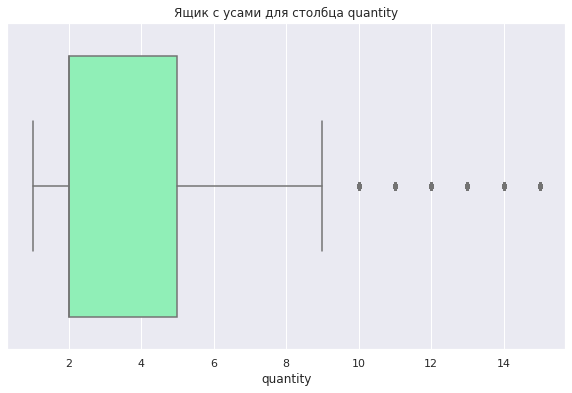

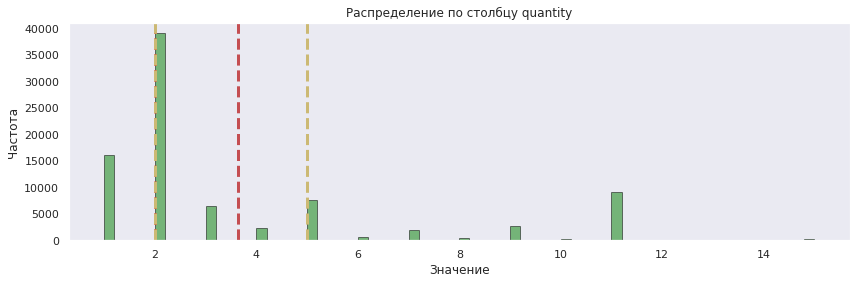

-----------------------------------------------------------


count    93389.000000
mean         4.618959
std          6.498030
min        -61.000000
25%          2.000000
50%          2.000000
75%          5.000000
max        143.000000
Name: quantity, dtype: float64

In [20]:

my_hist(data,'quantity')
data['quantity'].describe()

Существуют выбросы в данных о количестве купленных товаров, это весьма логично. Это ведь строительный магазин. Там можно купиь 1 молоток, а можно купить 20 гвоздей. Я не стала отбрасывать значения за пределами усов, потому что в данном случае все данные важны, по описаным выше причинам и стандратное отклонение не такое большое, значит данные равномерно распределены относително среднего. 

In [21]:
#data=data.query('quantity<= 12')

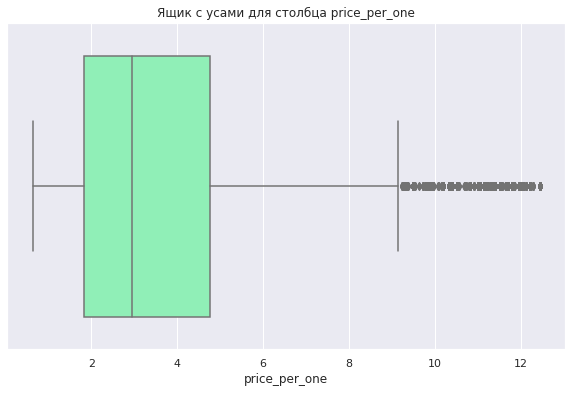

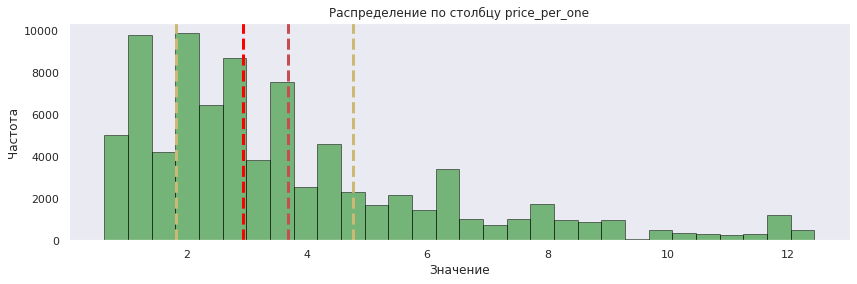

-----------------------------------------------------------


count    93389.000000
mean         4.084593
std          3.608568
min          0.120000
25%          1.762500
50%          2.948333
75%          5.100000
max         39.950000
Name: price_per_one, dtype: float64

In [22]:
my_hist(data,'price_per_one')
data['price_per_one'].describe()

Вот тут уже гистограмма совсем не показывает нам нормальное распределение, график выглдяит очень неравномерным и неупорядоченым. Видно, что после 3 квартиля идет некоторое возрастание в частоте товаров с увеличением цены, но после 7 у.е. идет резкий спад и далее частота встречаемости товаров с увеличением цены почти не меняется - их совсем немного, меньше 1000. Если говорить о менее дорогих товарах, сложно выявить какую-то логику в их распределении, но видно, что дешевых товаров явно больше, чем дорогих - скорее всего это какие-то строительные мелочи, опять-таки гвозди, шурупы, скотч и т.д., частоста их встречаемости держится больше 2000. 

P.S. Не была уверена стоит ли убирать тут выбросы, ведь если убирать выбросы за пределами ящика с усами, то много это нет даст, их там не так много, больше всего резких изменений как раз внутри ящика, так что я решила отсавить как есть. 

## Исследовательский анализ данных
Для начала давайте узнаем как отличается количество киентов с картой лояльности и без нее и проверим следующую гипотезу: 
### Количество клиентов с картой лояльности меньше, чем количество клиентов без нее

In [23]:
#создаем два датасета с данными по лояльным клиентам и остальным
loyal=data.query('loyalty_program==1')
n_loyal=data.query('loyalty_program==0')


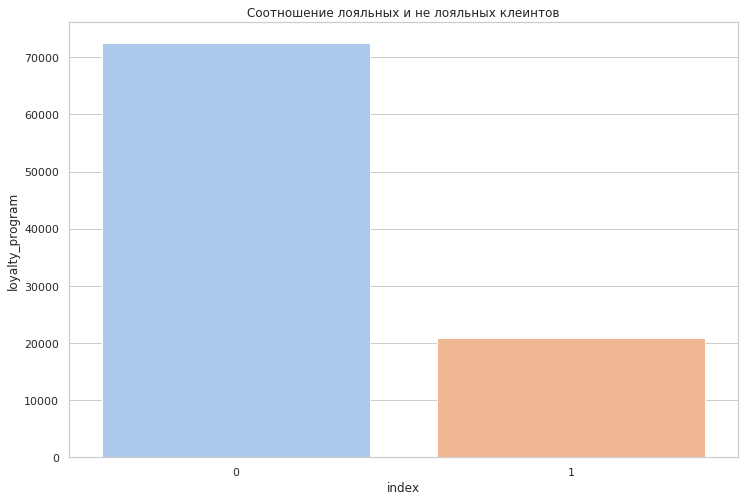

,index,loyalty_program,percent
0,0,72473,0.776034
1,1,20916,0.223966


In [24]:
loyal_data_1=data['loyalty_program'].value_counts().reset_index()

sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='whitegrid')
sns.barplot(x ='index',y='loyalty_program', data=loyal_data_1, palette = 'pastel')
plt.title('Соотношение лояльных и не лояльных клеинтов')
ax.tick_params(labelsize='large')
ax.set_xlabel('Лояльный и нелояльный клиент',fontsize=14,fontweight="bold")
ax.set_ylabel('Количество',fontsize=14,fontweight="bold")
plt.show()

loyal_data_1['percent']=loyal_data_1['loyalty_program']/(loyal_data_1['loyalty_program'][0]+loyal_data_1['loyalty_program'][1])
loyal_data_1

Видно, что не лояльных клиентов намного меньше, чем лояльных. Клиентов, пользующихся программой лояльности всего 21%. Это может быть связано с плохой рекламой карты лояльности, с тем, что участие в программе лояльности стоит денег, а так же с тем, кто клиенты не хотят учавствовать в программе лояльности, если они пришли в магазин один раз и больше никогда не возвращались, им могут быть неинтересны акции и скидки, если они делают покупки на небольшие суммы. Давайте же проверим как участие в программе лояльности зависит от среднего чека. 
### Средний чек у клиентов с картой лояльности больше


In [25]:
data.loc[data['bill']<0,'bill'].count()/data.shape[0]


0.01635096210474467

Чеков с возвратами у нас около 2% - это немного, но посомтрим как это повляется на разницу по среднему чеку.

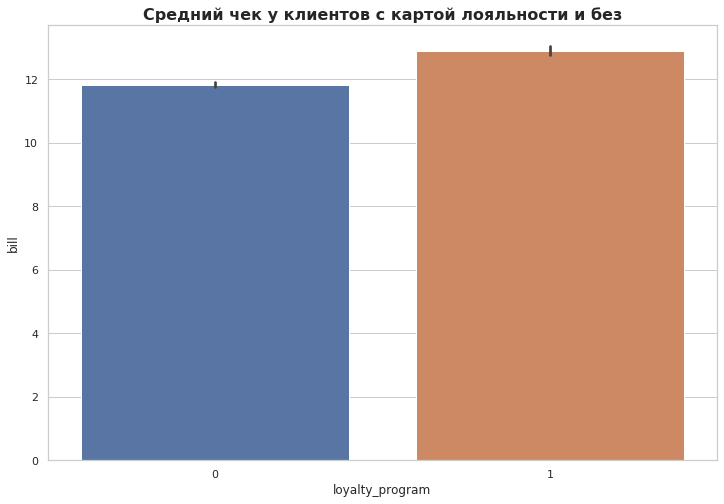

In [26]:
#с учетом возвратов
sns.barplot(x='loyalty_program', y='bill', data=data) 
plt.title('Средний чек у клиентов с картой лояльности и без',fontsize=16,fontweight="bold")
plt.show()


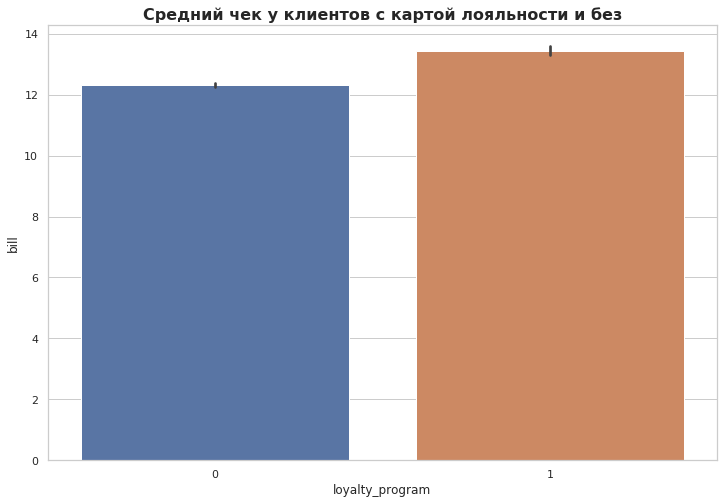

In [27]:
#теперь посмотрим на средний чек без возвратов.
data_without_return=data.query('bill>0')
sns.barplot(x='loyalty_program', y='bill', data=data_without_return) 
plt.title('Средний чек у клиентов с картой лояльности и без',fontsize=16,fontweight="bold")
plt.show()

У людей с картой лояльности средний чек больше и с учетом возвратов и без них. Ненамного, но все же больше, стоит помнить, что клиентов без карты лояльности больше, и даже такая разница показательна. Посмотрим на распределение чека для клиентов из наших двух групп. Выявлен первый плюс программы лояльности - клиенты покупают товары на большие суммы.

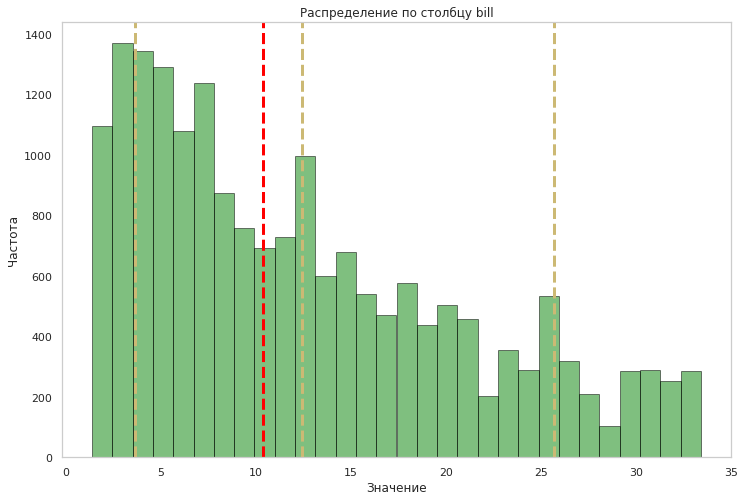

-----------------------------------------------------------


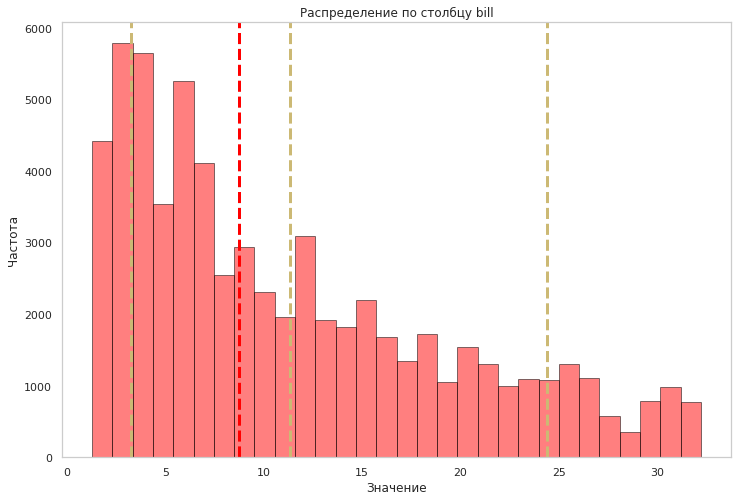

-----------------------------------------------------------


In [53]:
def only_hist(data,col,color):
    my_col=data.loc[(data[col]>=data[col].quantile(.05))&(data[col]<=data[col].quantile(.95)),col]# отбрасываем крайние значения
    hist=my_col.plot(kind='hist',# гистограмма
                    bins=num_of_bins(data,col),
                    alpha=0.5,
                    ec='black',
                    color=color)
    plt.axvline(x=my_col.median(),
               linewidth=3,
               color='red',
               linestyle='--')
    plt.axvline(x=my_col.mean(),
               linewidth=3,
               color='y',
               linestyle='--')
    plt.axvline(x=my_col.quantile(.15),
               linewidth=3,
               color='y',
               linestyle='--')
    plt.axvline(x=my_col.quantile(.90),
               linewidth=3,
               color='y',
               linestyle='--')
    plt.title('Распределение по столбцу '+col)
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.grid()
    plt.show()
    print('-----------------------------------------------------------')
    
    
only_hist(loyal,'bill','green')
only_hist(n_loyal,'bill','red')



Видно конечно, что частота покупок у клиентов без карты лояльности выше, но это связано лишь с тем, что клиентов без карты лояльности больше в разы. Заметно, что если сравнивать графики, то клиентов с картой лояльности примерно одинаковое количество для чеков больше чем на 2 у.е.,  с учетом разницы в количестве клиентов в группах - это говорит о том, что клиенты с картой лояльности все-таки чаще(если смотреть в процентом соотношении), чем остальные делают покупки на большие суммы. 


### Клиенты с картой лояльности делают меньше возвратов.

Когда мы смотрели данные методом  describe, то заметили, что в столбце с количеством товаров у нас были отрицательные значения. Скорее всего это возвраты. Чтобы проверить гипотезу о том, что клиенты с картой лояльности делают меньше возвратов, выберем из нашего датасета только те строки, где количество товаров в чеке отрицательное и сравним среднее количество возвратов для каждой группы. 

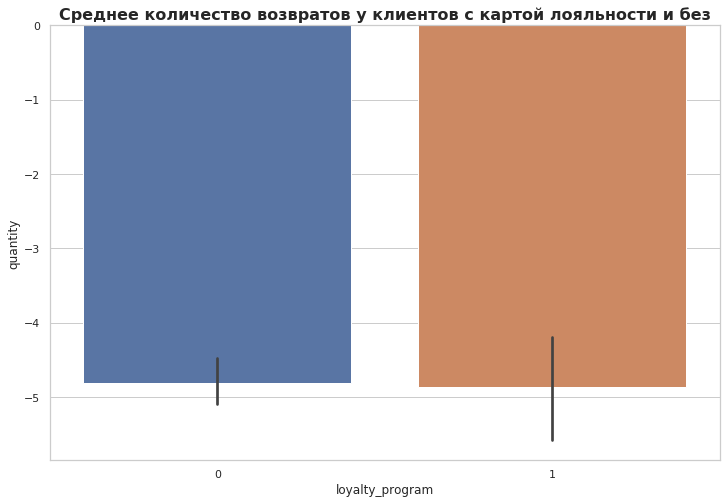

In [29]:
data_return=data.query('quantity<0')
sns.barplot(x='loyalty_program', y='quantity', data=data_return) 
plt.title('Среднее количество возвратов у клиентов с картой лояльности и без',fontsize=16,fontweight="bold")
plt.show()

По графику видно, что количество возвратов для клиентов с картой лояльности почти одинаковы, однако  клиенты с картой лояльности даже немного чаще делают возвраты. Давайте посмотрим методом describe и с группировкой по наличию карты лояльности на то насколько различен максимум, минимум, среднее и медиана для значения столбца quantity/


In [30]:
data_return.groupby('loyalty_program')['quantity'].describe()

,count,mean,std,min,25%,50%,75%,max
loyalty_program,,,,,,,,
0,1161.0,-4.808786,5.545233,-61.0,-5.0,-3.0,-2.0,-2.0
1,366.0,-4.857923,6.706491,-61.0,-4.0,-2.0,-2.0,-2.0


Видна небольшая разница между средним значением и стандартным отклонением, значит данные распределены равномерно. Можно сделать вывод, что клиенты делают возвраты с большей частотой, но и это не плохо. Может быть зайдут вернуть один товар и купят другой))




### Наличие карты лояльности и даты
#### Клиенты с картой лояльности делают покупки чаще

Посмотрим на распределение количества покупок по времени, уберем временной показатель из столбца с датой и временем и возьмем только даты.

In [31]:
data['purchase_date']=data['purchase_date'].astype('datetime64[D]')
data.head()


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,bill
0,538280,21873,11.0,2016-12-10,18427.0,Shop 0,0,1.810000,19.910000
1,538862,22195,2.0,2016-12-14,22389.0,Shop 0,1,2.766667,5.533333
2,538855,21239,7.0,2016-12-14,22182.0,Shop 0,1,1.474000,10.318000
3,543543,22271,2.0,2017-02-09,23522.0,Shop 0,1,4.300000,8.600000
4,543812,79321,2.0,2017-02-13,23151.0,Shop 0,1,7.715000,15.430000


Теперь посмотрим на количество покупателей по дням. 

In [54]:
def analysis(data,col):
    fig = px.line(data.pivot_table(index = ['loyalty_program', 'purchase_date'], values = col, aggfunc = 'count').reset_index(), x = 'purchase_date', y = col, color = 'loyalty_program', title = ' Количество клиентов по дням')
    fig.show()    
analysis(data,'customer_id')

In [33]:
data_date=data.query('purchase_date>"2017-01-04"')

2228/data_date.loc[data_date['loyalty_program']==0,'customer_id'].count()

0.05193231084797911

Видно, что и по количеству покупателей с картой лояльности и без нее, есть небольшой спад по кол-ву покупателей в день с начала декабря до 23 числа. Потом у нас отсутсвуют данные с 23.12 по 4.01 - скорее всего в эти праздничные дни магазин не работал. а после этого мы видим, что график для клиентов без карты лояльности является более "резким" с крутыми перепадами, в один день можно быть 294 клиента, а в другой 2200, график для клиентов с картой лояльности более стабильный. Так диапазон графика для клиентов без карты лояльности от 149 до 2749 за весь период, что составляет 0,2% и 4% от общего количества клиентов без карты. А диапазон графика клиентов с картой лояльности - от 54 до 889 за весь период, что состовляет 0,3% и 4,3% от общего числа клиентов с картой. Но более показательными будут числа, если смотреть данные с 4 января. 

Так, диапазон для клиентов без карты от 149 до 2228, что составляет 0,35% и 5,3%.
Диапазон для клиентов с картой от 105 до 512, что состовляет 0,9% и 4,3%.

Видно, что разброс больше, но при этом минимальный процент покупателей во всех случаях выше для клиентов с картой лояльности, а максимальный процент выше, если брать весь период времени.
Можно выявить еще один плюс программы лояльности -  клиенты с картой лояльности регулярнее и чаще приходят в магазин.

Построим по такому же принципу график для чеков на каждый день и посмотрим разброс и частоту.

In [55]:
data_for_line=data.pivot_table(index=['loyalty_program','purchase_date'], values='purchase_id', aggfunc='count')

def analysis(data,col):
    fig = px.line(data_for_line.reset_index(), x = 'purchase_date', y = col, color = 'loyalty_program', title = ' Количество продаж по дням')
    fig.show()    
analysis(data,'purchase_id')

Наблюдаем примерно такую же картину, что только подверждает наши выводы. Давайте еще ради инетереса посмотрим распределение по дням недели, может в какие-то дни клиенты приходят чаще чем в другие

In [35]:
data['purchase_date_w']=data['purchase_date'].dt.dayofweek
data.head()


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,bill,purchase_date_w
0,538280,21873,11.0,2016-12-10,18427.0,Shop 0,0,1.810000,19.910000,5
1,538862,22195,2.0,2016-12-14,22389.0,Shop 0,1,2.766667,5.533333,2
2,538855,21239,7.0,2016-12-14,22182.0,Shop 0,1,1.474000,10.318000,2
3,543543,22271,2.0,2017-02-09,23522.0,Shop 0,1,4.300000,8.600000,3
4,543812,79321,2.0,2017-02-13,23151.0,Shop 0,1,7.715000,15.430000,0


In [56]:
def analysis(data,col):
    fig = px.line(data.pivot_table(index = ['loyalty_program', 'purchase_date_w'], values = col, aggfunc = 'count').reset_index(), x = 'purchase_date_w', y = col, color = 'loyalty_program', title = ' Количество клиентов по дням недели')
    fig.show()    
analysis(data,'customer_id')

Видно, что клиенты с картой лояльности почти одинакого ходят в наш магазин на протяжении всей недели. Может быть карты лояльности имеют не только обычные клиенты, но и бригадиры, которые закупают материалы для ремонта по необходимости, это может объяснить почему в будни покупают чаще, чем в выходные. А вот у клиентов без карты лоялности нет времени по будням ходить по магазинам, зато в воскресене они готовы хоть весь день тут провести. В графике для лояльных клиентов нет резких спадов или подъемов, они одинакого часто ходят в наш магазин. 

Еще один плюс программы лояльности - клиенты ходят регулярно. 


Посмотрим еще средний чек по дням.

In [44]:
def analysis(data,col):
    fig = px.line(data.pivot_table(index = ['loyalty_program', 'purchase_date'], values = col, aggfunc = 'mean').reset_index(), x = 'purchase_date', y = col, color = 'loyalty_program', title = 'Сумма чека по дням')
    fig.show()    
analysis(data,'bill')

Опять таки видно, что средний чек для клиентов с картой лояльности почти всегда выше. Посмотрим по сумме чека.

In [57]:
def analysis(data,col):
    fig = px.line(data.pivot_table(index = ['loyalty_program', 'purchase_date'], values = col, aggfunc = 'sum').reset_index(), x = 'purchase_date', y = col, color = 'loyalty_program', title = ' Средний чек по дням')
    fig.show()    
analysis(data,'bill')

Так же как и с количеством покупателей или покупок, график для клиентов с картой лояльности стабильнее. 

### Программы лояльности имеют разный уровень популярности в разных магазинах

In [39]:
print('Loyal programm in')
print( loyal['shop_id'].unique())
print('doesn t have a loyal  programm in')
print( n_loyal['shop_id'].unique())

Loyal programm in
['Shop 0' 'Shop 8' 'Shop 28' 'Shop 19']
doesn t have a loyal  programm in
['Shop 0' 'Shop 1' 'Shop 6' 'Shop 2' 'Shop 11' 'Shop 4' 'Shop 5' 'Shop 3'
 'Shop 7' 'Shop 12' 'Shop 8' 'Shop 27' 'Shop 20' 'Shop 19' 'Shop 25'
 'Shop 18' 'Shop 10' 'Shop 16' 'Shop 29' 'Shop 17' 'Shop 22' 'Shop 14'
 'Shop 9' 'Shop 26' 'Shop 15' 'Shop 21' 'Shop 13' 'Shop 30' 'Shop 24']


Уже тут видно, что магазины сразу деляться на те, где есть программа лояльности и те, где ее нет.

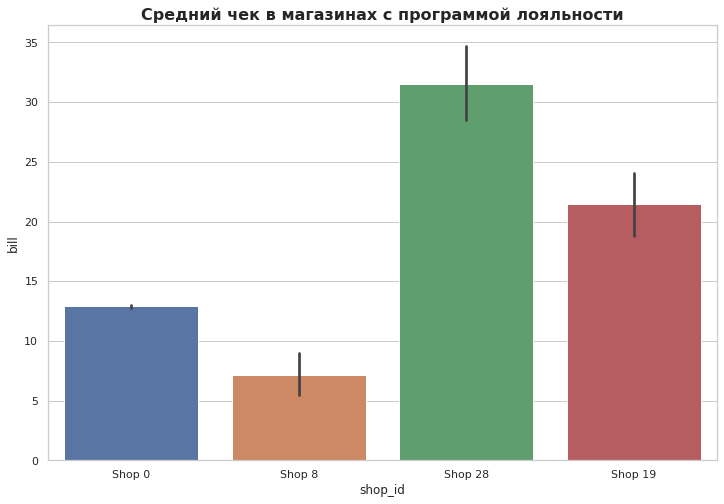

In [52]:
sns.barplot(x='shop_id', y='bill', data=data.query('loyalty_program==1') ) 
plt.title('Средний чек в магазинах с программой лояльности',fontsize=16,fontweight="bold")
plt.show()

Видно, что программа лояльности имеет разный уровень популярности в разных магазинах. Это может быть связано с географическим положением магазина или проведением рекламной компании нашей программы лояльности, давайте посмотрим соотношение по разным магазинам клиентов с картой лояльнсоти и без количества клиентов. 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

posx and posy should be finite values
posx and posy should be finite values


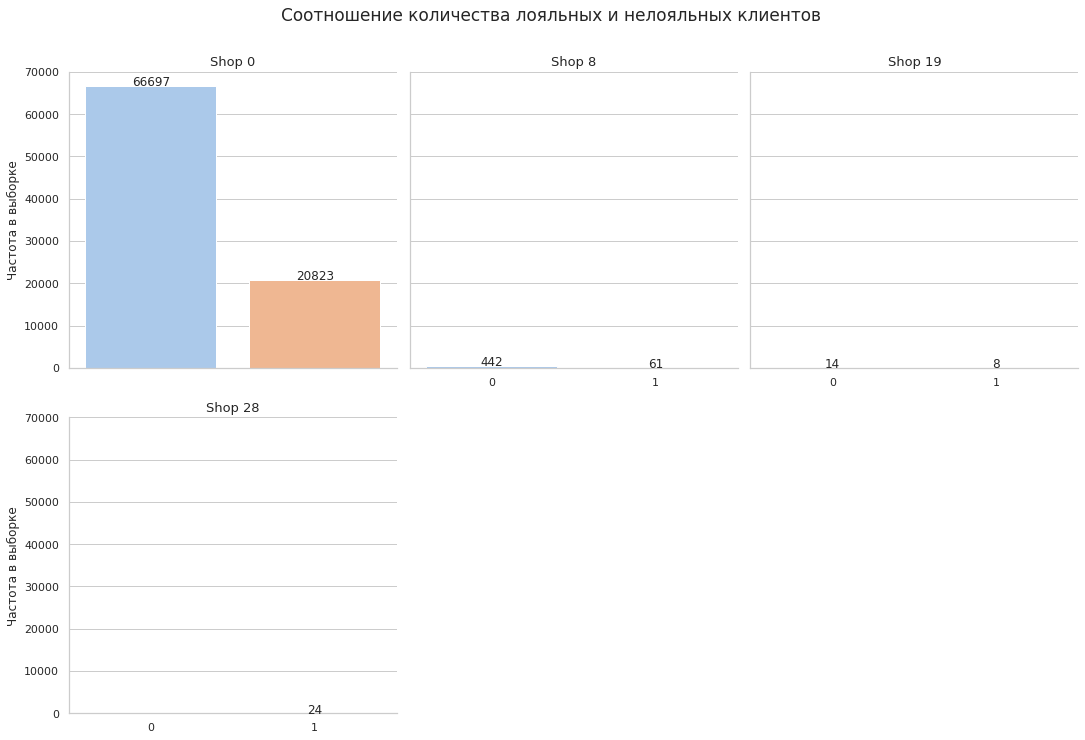

In [58]:

ax = fig.add_subplot(111)
shop_list=loyal['shop_id'].unique()
data_shops=data.query('shop_id in @shop_list')
every= sns.catplot(
    x="loyalty_program",
    col="shop_id",
    col_wrap=3,
    kind="count",
    data=data_shops,
    aspect=1,
    palette='pastel'
)
every.set_axis_labels("","Частота в выборке")
every.fig.suptitle("Соотношение количества лояльных и нелояльных клиентов", y=1.05, fontsize=17)
every.set_titles("{col_name}",size=13)
for ax in (every.axes):
    for p in ax.patches:
        height=p.get_height()
        ax.text(
            x=p.get_x()+(p.get_width()/2),
            y=height+10,
            s="{:.0f}".format(height),
            ha="center"
        )
plt.show()

В принципе видно, что распределение клентов с картой лояльности и без нее у нас такое как в пункте 5.1. Только в Shop 28 кажется нет клиентов  без карты лояльности, но их в целом там немного. Можно проработать этот вопрос с отделом маркетинга и начать продвигать программу лоляьности в магазинах, где она не так сильно распространена и в тех, где ее на данный момент нет.


P.S.  В декомпозиции я еще писала два пункта, разбиение по группам и тд, но потом начала их деоать и поняла, что ничего нового не узнала, выводы те же самые, что в пунктах выше, так что не стала их писать. 
## Документация
Пришлось перетрясти свою историю поиска))

Во время работы над проектом я часто обращалась к своим прошлым проектам и теории тренажера. Так же пользовалась следующими сайтами:
* http://statistica.ru/theory/opisatelnye-statistiki/ - использовала сайт, чтобы восстановить в голове работу со стат выбросами, что такое перцентили и стандартное отклонение, что оно показывает и как его усмирить
* https://www.machinelearningmastery.ru/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623/ - статья про работу с выбросами, очень помогла вспомнить основную теорию про boxplot и гистограммы и как с ними работать
* https://habr.com/ru/company/otus/blog/540526/ - seaborn, теория похожа на ту, что есть у нас в тренажере, иногда путала какие параментры писать для того же боксплота в seaborn и в plt, а тут есть почти все нужные мне виды графиков  с примерами, так что очень помогло
* https://question-it.com/questions/941776/peredacha-obekta-tipa-datetime-v-seabornlmplot - сначала были проблемы с построением графика по датам, после этого стало полегче, ну еще заглянула в прошлые проекты
* https://habr.com/ru/post/502958/ - очередная любимая шпаргалка с habr, с примерами и пояснениями, всем я, конечно, не воспользовалась, но это потому что поджимало время((
* https://tableau.pro/m01 - не знаю, можно ли использовать это в документации, но я начала проходить этот курс и подчерпнула разные вещи оттуда 
* https://praktikum.yandex.ru/learn/data-analyst/courses/295314ef-a66a-4b2e-a47f-ef5584ae9183/sprints/3778/topics/0aa93cf5-8048-4043-bf68-4197ad50e9f7/lessons/28581282-a18e-4484-93d8-ced616bd89aa/ - сслыка на урок из ЯП, пользовалась при создании дашборда всем блоком, потому что многое не уложилось в памяти с первого раза, но здесь информация о типах графиков, которые я использовала, так что было полезно. 

В остальном получилось сработать методом проб и ошибок, ну и конечно не без помощи коллег в slack и telegram


## Презентация
Ссылка: https://drive.google.com/file/d/1mnYLfcybwcgQhPzxxG22Lg8b7bR42yEb/view?usp=sharing

## Дашборд
https://public.tableau.com/views/retail_16271064673040/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link
я выбрала первый набор, но добавила еще первый график из второго набора, выбор магазина, времени в фильтрах. и добавила piechart с процентным соотношением количества клиентов, а так же на графиках видно разделение на лояльных и нелояльных клиентов по цвету. 

## Выводы

Нашей задачей было выявить различия между клиентами с картой лояльности и без нее, вот что из этого вышло:
* количество клиентов с картой лояльности меньше, чем без нее. Клиентов с картой лояльности всего около 22%, а без нее 78%
* Средний чек клиентов с картой лояльности выше, хоть на первый взгляд и незначительно
* Клиенты с картой лояльности и без нее делают одинаковое количество возвратов
* Клиенты с картой лояльность делают покупки чаще и регулярнее приходят в магазин, чем нелояльные клиенты. Лояльные клиенты более стабильны и имеют свойство возвращаться в магазин, нежели делать одну покупку и больше никогда не приходить
* Клиенты без карты лояльности чаще всего делают покупки в воскресение, можно воспользоваться этим моментом и может быть пустить более активную рекламу программы лояльности в этот день, когда поток клиентов больше.
* программа лояльности пока внедрена только в 4 магазинах и в каждом из них, клиентов учавствующих в ней меньше, чем не учавствующих.  В остальных 26 магазинах программа не внедрена, стоит заняться этим вопросом. 


